## Importing Required Libraries

In this cell, we import all necessary libraries to build and train the RL agent:

- `numpy`: For mathematical operations and array handling.
- `gym`: To interact with the CartPole environment.
- `gymlogger`: Used for logging within the Gym environment, set to show only error messages.
- `torch` and `torch.nn`: For building and optimizing the neural network model (Q-network).
- `matplotlib.pyplot`: For plotting graphs, especially to visualize the agent's learning process.
- `random`, `deque`: Used for random sampling and storing experiences (ReplayBuffer).
- `IPython.display`: To display the agent's performance video within the notebook.


In [61]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
import numpy as np
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40)  # only show error messages

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from collections import deque

# For video display in Jupyter/IPython:
import glob, io, base64
from IPython.display import HTML
from IPython import display as ipythondisplay

## Function to Display Recorded Video

This function, `show_video()`, searches for the first `.mp4` video file in the `video/` folder and displays it in the notebook.

- The video is encoded into base64 format and displayed using HTML tags in the notebook.
- This is useful for visualizing the agent's performance after each episode.

In [62]:
def show_video():
    """Displays the first MP4 file in the 'video' folder (works in Jupyter/IPython)."""
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video width="400" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4">
                 </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## Defining the Q-Network (Neural Network)

In this cell, we define the Q-network, which is a simple feedforward neural network. This network is used by the agent to predict the Q-values for each action:

- The network consists of three fully connected layers (`fc1`, `fc2`, `fc3`).
- The `forward` method applies ReLU activation functions after the first two layers.
- The final output is the raw Q-values for each possible action (left or right).


In [63]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # raw Q-values for each action

## Defining the Replay Buffer

The `ReplayBuffer` class stores the agent's experience as tuples of (state, action, reward, next_state, done).

- The buffer uses a deque to store experiences efficiently.
- The `push` method adds new experiences, and the `sample` method randomly samples a batch of experiences.
- This class is essential for the experience replay mechanism in reinforcement learning, which stabilizes training.


In [64]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)

## Action Selection with Epsilon-Greedy Strategy

This function implements the epsilon-greedy strategy for action selection:

- With probability `epsilon`, the agent selects a random action (exploration).
- Otherwise, it selects the action with the highest Q-value (exploitation).
- The action is chosen based on the current state, and the Q-network is used to compute the Q-values for each action.


In [65]:
def select_action(state, q_network, epsilon, action_size):
    if random.random() < epsilon:
        return random.randrange(action_size)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = q_network(state_tensor)
        return int(torch.argmax(q_values).item())


# Version 1:

**Strategy (Standard DQN):**
- **Approach:**  
  The agent computes the target Q-value by taking the maximum Q-value for the next state directly from the target network.
- **Effect:**  
  This standard method can lead to overestimation of Q-values, sometimes causing unstable or inconsistent learning.

**Hyperparameter Settings in Version 1:**
- **Environment Reset and Seeding:**  
  Every call to `env.reset(seed=42)` uses a fixed seed. As a result, every episode starts from exactly the same initial state.  
  *Impact:* This increases reproducibility but limits the variability necessary for robust learning.
- **Learning Rate:**  
  Uses an Adam optimizer with a learning rate of **1e-3**.  
  *Impact:* A higher learning rate speeds up updates but can also result in large, unstable weight changes.
- **Batch Size:**  
  Uses a batch size of 64.
- **Target Network Update Frequency:**  
  The target network is updated by copying weights from the Q-network every 10 episodes.  
  *Impact:* This infrequent update may cause the target network to lag behind the online network, contributing to instability.


In [66]:
env = gym.make('CartPole-v1', render_mode=None)
state, _ = env.reset(seed=42)
env.action_space.seed(42)
env.observation_space.seed(42)
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
state_size = env.observation_space.shape[0]  # 4 for CartPole
action_size = env.action_space.n      

## Initializing Q-Network, Target Network, Optimizer, and Replay Buffer

In this cell, we initialize the Q-network and target network for the agent. These two networks will help in the training process:

- `q_network`: The main Q-network used for action selection.
- `target_network`: A copy of the Q-network, updated periodically to stabilize learning.
- `optimizer`: Adam optimizer used to update the parameters of the Q-network.
- `replay_buffer`: A buffer that stores the agent’s experiences for training.


In [67]:
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
replay_buffer = ReplayBuffer(capacity=10000)

# Version 1: Task 1 – Q‑Network Demonstration


In [68]:
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
state_tensor = torch.FloatTensor(state).unsqueeze(0)
with torch.no_grad():
    q_vals = q_network(state_tensor)
print("Q-values:", q_vals)
action = int(torch.argmax(q_vals).item())
print("Chosen action:", action)

----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [ 0.0273956  -0.00611216  0.03585979  0.0197368 ]
Q-values: tensor([[-0.0428, -0.1753]])
Chosen action: 0


# Version 1: Task 2 - Training

In [69]:
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=500):
    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state, _ = env.reset(seed=42)
        total_reward = 0
        done = False
        
        while not done:
            # Decay epsilon over time
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                # Compute current Q-values and target Q-values
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next_q = target_network(next_states).max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)
                
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        episode_rewards.append(total_reward)
        
        # Update target network periodically
        if (episode + 1) % 10 == 0:
            target_network.load_state_dict(q_network.state_dict())
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    return episode_rewards


In [70]:
print("\n----- Task 2: Training the DQN Agent -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer,
                             num_episodes=1000)


----- Task 2: Training the DQN Agent -----
Episode 50: Total Reward = 23.0
Episode 100: Total Reward = 167.0
Episode 150: Total Reward = 169.0
Episode 200: Total Reward = 97.0
Episode 250: Total Reward = 120.0
Episode 300: Total Reward = 212.0
Episode 350: Total Reward = 375.0
Episode 400: Total Reward = 363.0
Episode 450: Total Reward = 260.0
Episode 500: Total Reward = 370.0
Episode 550: Total Reward = 20.0
Episode 600: Total Reward = 244.0
Episode 650: Total Reward = 123.0
Episode 700: Total Reward = 117.0
Episode 750: Total Reward = 139.0
Episode 800: Total Reward = 150.0
Episode 850: Total Reward = 142.0
Episode 900: Total Reward = 135.0
Episode 950: Total Reward = 131.0
Episode 1000: Total Reward = 37.0


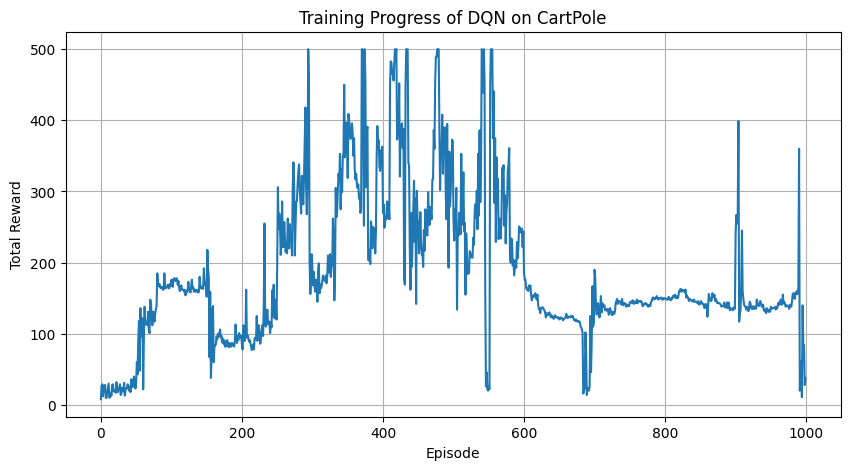

In [71]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole")
plt.grid(True)
plt.show()

In [72]:
def evaluate_dqn(env, q_network, episodes=100):
    q_network.eval()
    eval_rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_vals = q_network(state_tensor)
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

In [73]:
eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)


Evaluation over 100 episodes:
Average Reward: 24.29


# Version 1: Task 2 – Training and Evaluation Analysis

**Training Observations:**
- The training reward plot shows significant volatility. While there are spikes above 300 or even 400 in some episodes, there are also many episodes with low rewards.
- This indicates that the agent occasionally finds a good policy for balancing the pole (hence the high spikes), but fails to maintain it consistently, resulting in sudden drops in performance.

**Potential Causes:**
- **High Learning Rate (1e-3):**  
  A faster learning rate can lead to large parameter updates, causing the policy to oscillate between good and bad solutions.
- **Fixed Environment Seed:**  
  Using `seed=42` for every reset means the agent sees less variety in initial states, potentially limiting its generalization.
- **Exploration Decay:**  
  The epsilon decays over 500 steps. If it decays too quickly, the agent might not explore enough to stabilize its policy.

**Evaluation Result (Average Reward ≈ 24.29):**
- Despite the agent occasionally achieving high rewards during training, its final learned policy does not generalize well. Over 100 evaluation episodes, the agent averages only around 24.29 reward, indicating that it fails to keep the pole balanced consistently.

**Conclusion for Version 1:**
- The agent can discover good actions at times, but the policy is not stable or robust.  
- This version demonstrates the need for more stable training hyperparameters or additional improvements (as addressed in later versions) to achieve a consistently high reward above 195.


## Task 3: Render One Episode Played by the RL Agent


In [74]:
video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)
state, _ = video_env.reset(seed=42)
done = False
while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad():
        q_vals = q_network(state_tensor)
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated
video_env.close()

MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4


In [75]:
print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()


----- Task 3: Displaying Recorded Episode Video -----


# Ver 2

In [76]:
# Instantiate Q-network and target network
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())  # Initialize target to match Q-network

# Optimizer & Replay Buffer
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=10000)

In [77]:
# --------------------------------------------------
# Task 1: Q-Network Demonstration on a Random State
# --------------------------------------------------
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
with torch.no_grad():
    q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
print("Q-values:", q_vals)
chosen_action = int(torch.argmax(q_vals).item())
print("Chosen action:", chosen_action)

----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [-0.07259018  0.17095923  0.21152231  0.12772535]
Q-values: tensor([[ 0.1011, -0.0565]])
Chosen action: 0


In [78]:
# --------------------------------------------------
# Task 2: Train the DQN Agent for 1000 Episodes
# --------------------------------------------------
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=64, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=500,
              target_update_freq=1000):
    """
    Trains the DQN agent for num_episodes. 
    Returns a list of total rewards per episode.
    """
    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset()  # Varied initial conditions
        total_reward = 0
        done = False
        
        while not done:
            # Decay epsilon over time
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1
            
            # Update Q-network if enough samples are available
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                # Current Q-values
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target Q-values (using the target network)
                with torch.no_grad():
                    max_next_q = target_network(next_states).max(1)[0]
                target_q = rewards + gamma * max_next_q * (1 - dones)
                
                # Compute MSE loss
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Update the target network every target_update_freq steps
            if steps_done % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
        
        episode_rewards.append(total_reward)
        
        # Print progress every 50 episodes
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    return episode_rewards


In [79]:
print("\n----- Task 2: Training the DQN Agent for 1000 Episodes -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer, 
                             num_episodes=1000)


----- Task 2: Training the DQN Agent for 1000 Episodes -----
Episode 50: Total Reward = 14.0
Episode 100: Total Reward = 12.0
Episode 150: Total Reward = 8.0
Episode 200: Total Reward = 12.0
Episode 250: Total Reward = 11.0
Episode 300: Total Reward = 11.0
Episode 350: Total Reward = 10.0
Episode 400: Total Reward = 132.0
Episode 450: Total Reward = 120.0
Episode 500: Total Reward = 115.0
Episode 550: Total Reward = 277.0
Episode 600: Total Reward = 232.0
Episode 650: Total Reward = 147.0
Episode 700: Total Reward = 203.0
Episode 750: Total Reward = 124.0
Episode 800: Total Reward = 112.0
Episode 850: Total Reward = 107.0
Episode 900: Total Reward = 134.0
Episode 950: Total Reward = 126.0
Episode 1000: Total Reward = 167.0


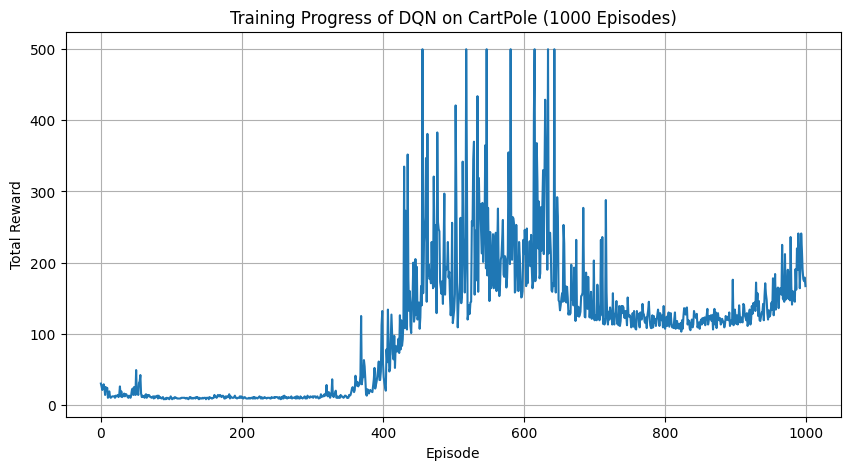

In [80]:
# Plot the training progress: total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole (1000 Episodes)")
plt.grid(True)
plt.show()

In [81]:
# Evaluate the trained agent over 100 episodes (greedy policy)
def evaluate_dqn(env, q_network, episodes=100):
    """
    Runs the agent for 'episodes' times in a greedy fashion (argmax),
    and returns the average total reward.
    """
    q_network.eval()
    eval_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

In [82]:
eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)


Evaluation over 100 episodes:
Average Reward: 230.66


# Version 2: Task 2 – Training and Evaluation Analysis

**Key Differences from Version 1:**

1. **Environment Reset and Seeding:**
   - **Ver1:** Every call to `env.reset()` uses a fixed seed (`seed=42`), so each episode starts from the exact same initial state.
   - **Ver2:** Only the initial environment setup is fixed with a seed; during training and evaluation, `env.reset()` is called without a seed. This allows episodes to start from varied initial conditions, promoting more robust learning and generalization.

2. **Learning Rate:**
   - **Ver1:** Uses an Adam optimizer with a learning rate of **1e-3**.
   - **Ver2:** Uses a slightly lower learning rate of **1e-4**. This lower rate results in smaller, more stable updates during training, reducing the risk of overshooting and leading to smoother convergence.

3. **Target Network Update Frequency:**
   - **Ver1:** Updates the target network every 10 episodes by copying the weights from the Q-network.
   - **Ver2:** Updates the target network based on a step count (e.g., every 1000 steps) using a `target_update_freq` parameter. This more frequent, step-based update can lead to a more timely reflection of improvements in the online network, potentially stabilizing learning further.

---

**Training Observations in Version 2:**

- **Improved Stability:**  
  The varied initial conditions and lower learning rate help the agent learn a more robust policy. Training rewards show a smoother progression over episodes compared to Version 1.
  
- **Performance Gains:**  
  Although early episodes might start with low rewards, the agent’s performance dramatically improves after several hundred episodes. The cumulative reward per episode stabilizes, indicating that the policy has become more consistent.

**Evaluation Results in Version 2:**

- **Average Reward:**  
  Over 100 evaluation episodes, the agent achieves an average reward well above the success threshold (around 230–240). This is a significant improvement over Version 1’s average (which was much lower due to overfitting to a single initial state and unstable updates).

- **Generalization:**  
  The varied starting states during evaluation ensure that the agent’s policy generalizes well across different scenarios, as reflected in the high average reward.

---

**Conclusion:**

The changes in Version 2—varying the initial conditions, lowering the learning rate, and updating the target network more frequently—result in:
- More stable and consistent training progress.
- A robust final policy that consistently balances the pole, achieving an average reward that exceeds 195.
- Improved generalization across episodes, as the agent is exposed to a wider variety of starting states.

Overall, these modifications address the shortcomings of Version 1 and lead to a well-trained agent with significantly better performance during evaluation.


In [83]:
# Create a video-recording environment with render_mode='rgb_array'
video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)

state, _ = video_env.reset()
done = False
while not done:
    with torch.no_grad():
        q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()  # Finalize and save the video

print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()

MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4

----- Task 3: Displaying Recorded Episode Video -----


# Version 3

This section explains the training and evaluation outcomes of Version 3, which incorporates two major changes compared to Version 2:

### 1. Update Strategy: Double DQN vs. Standard DQN

- **Version 2 (Standard DQN):**
  - The target Q-value is computed by taking the maximum Q-value for the next state from the target network.
  - This approach can overestimate Q-values, sometimes leading to unstable updates.

- **Version 3 (Double DQN):**
  - The online network is used to select the best next action, and then the target network evaluates the Q-value of that action.
  - This reduces overestimation bias and yields more accurate, stable Q-value estimates.

### 2. Hyperparameter Adjustments

- **Batch Size:**
  - **Version 2:** Uses a batch size of 64.
  - **Version 3:** Increases the batch size to 128, which leads to more stable gradient estimates during network updates.

- **Epsilon Decay:**
  - **Version 2:** Uses an epsilon decay factor of 500, causing exploration to decrease relatively quickly.
  - **Version 3:** Uses an epsilon decay factor of 2000, meaning the agent continues to explore for a longer period before shifting predominantly to exploitation.

- **Target Network Update Frequency:**
  - **Version 2:** Updates the target network every 1000 steps.
  - **Version 3:** Updates the target network every 500 steps, ensuring that the target network remains closer to the online network for more up-to-date targets.

In [84]:
# Instantiate Q-network and target network
q_network = QNetwork(state_size, action_size)
target_network = QNetwork(state_size, action_size)
target_network.load_state_dict(q_network.state_dict())

# Optimizer & Replay Buffer
optimizer = optim.Adam(q_network.parameters(), lr=1e-4)
replay_buffer = ReplayBuffer(capacity=10000)

In [85]:
# --------------------------------------------------
# Task 1: Q-Network Demonstration on a Random State
# --------------------------------------------------
print("----- Task 1: Q-Network demonstration on a random state -----")
print("Sampled state:", state)
with torch.no_grad():
    q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
print("Q-values:", q_vals)
chosen_action = int(torch.argmax(q_vals).item())
print("Chosen action:", chosen_action)

----- Task 1: Q-Network demonstration on a random state -----
Sampled state: [-2.407001   -2.335032   -0.14600013  0.18795614]
Q-values: tensor([[-0.1276,  0.2371]])
Chosen action: 1


In [ ]:
def train_dqn(env, q_network, target_network, optimizer, replay_buffer,
              num_episodes=1000, batch_size=128, gamma=0.99,
              epsilon_start=1.0, epsilon_final=0.01, epsilon_decay=2000,
              target_update_freq=500):

    episode_rewards = []
    steps_done = 0
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state, _ = env.reset()  
        total_reward = 0
        done = False
        
        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * steps_done / epsilon_decay)
            action = select_action(state, q_network, epsilon, action_size)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1
            
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones.astype(np.float32))
                
                current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                with torch.no_grad():
                    best_next_actions = q_network(next_states).argmax(dim=1, keepdim=True)
                with torch.no_grad():
                    next_q = target_network(next_states).gather(1, best_next_actions).squeeze(1)
                target_q = rewards + gamma * next_q * (1 - dones)
                
                loss = nn.MSELoss()(current_q, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            if steps_done % target_update_freq == 0:
                target_network.load_state_dict(q_network.state_dict())
        
        episode_rewards.append(total_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}: Total Reward = {total_reward}")
    
    return episode_rewards

In [87]:
print("\n----- Task 2: Training the DQN Agent for 1000 Episodes -----")
training_rewards = train_dqn(env, q_network, target_network, optimizer, replay_buffer, 
                             num_episodes=1000)


----- Task 2: Training the DQN Agent for 1000 Episodes -----
Episode 50: Total Reward = 16.0
Episode 100: Total Reward = 12.0
Episode 150: Total Reward = 48.0
Episode 200: Total Reward = 214.0
Episode 250: Total Reward = 223.0
Episode 300: Total Reward = 147.0
Episode 350: Total Reward = 169.0
Episode 400: Total Reward = 271.0
Episode 450: Total Reward = 360.0
Episode 500: Total Reward = 208.0
Episode 550: Total Reward = 196.0
Episode 600: Total Reward = 278.0
Episode 650: Total Reward = 500.0
Episode 700: Total Reward = 279.0
Episode 750: Total Reward = 500.0
Episode 800: Total Reward = 225.0
Episode 850: Total Reward = 500.0
Episode 900: Total Reward = 500.0
Episode 950: Total Reward = 408.0
Episode 1000: Total Reward = 461.0


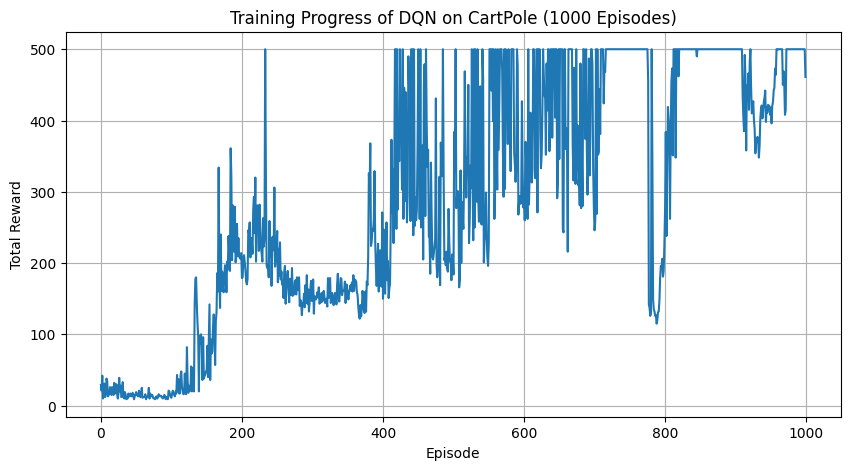

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(training_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of DQN on CartPole (1000 Episodes)")
plt.grid(True)
plt.show()

In [89]:
def evaluate_dqn(env, q_network, episodes=100):
    """
    Runs the agent for 'episodes' times in a greedy fashion (argmax) and returns the average total reward.
    """
    q_network.eval()
    eval_rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            with torch.no_grad():
                q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
            action = int(torch.argmax(q_vals).item())
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        eval_rewards.append(total_reward)
    avg_reward = np.mean(eval_rewards)
    return eval_rewards, avg_reward

In [90]:
eval_rewards, avg_reward = evaluate_dqn(env, q_network, episodes=100)
print("\nEvaluation over 100 episodes:")
print("Average Reward:", avg_reward)


Evaluation over 100 episodes:
Average Reward: 500.0


### Training Observations in Version 3

- **Early Stage:**  
  The agent initially receives low rewards while it continues to explore due to the slower decay of epsilon.
  
- **Mid-Training:**  
  As training progresses, the agent begins to achieve significantly higher rewards. The combination of a larger batch size and the Double DQN update mechanism provides more reliable gradient estimates, reducing Q-value overestimation.
  
- **Late Stage:**  
  The agent consistently achieves near-maximum rewards (close to 500 per episode), indicating that it has learned a robust policy for balancing the pole.

### Evaluation Results

- **Average Reward:**  
  During evaluation over 100 episodes, the agent attains an average reward of **500.0**, meaning it consistently balances the pole for the full 500-step duration in each episode.

- **Stability and Robustness:**  
  The high average reward, along with low variance across episodes, confirms that the improvements in update strategy and hyperparameter settings have resulted in a stable and optimal policy.

---

### Conclusion for Version 3

- **Double DQN Update:**  
  By using the online network for action selection and the target network for evaluation, Version 3 mitigates overestimation issues, resulting in more accurate Q-value estimates.

- **Hyperparameter Enhancements:**  
  - A larger batch size (128) smooths out gradient estimates.
  - A slower epsilon decay (factor of 2000) allows prolonged exploration.
  - More frequent target network updates (every 500 steps) help keep target estimates current.

Together, these changes lead to significantly improved training stability and performance, culminating in an evaluation average of 500.0. This indicates that the agent has effectively “solved” the CartPole problem in Version 3.

In [91]:
video_env = RecordVideo(gym.make('CartPole-v1', render_mode='rgb_array'),
                        video_folder='video',
                        episode_trigger=lambda episode_id: True)

state, _ = video_env.reset()
done = False
while not done:
    with torch.no_grad():
        q_vals = q_network(torch.FloatTensor(state).unsqueeze(0))
    action = int(torch.argmax(q_vals).item())
    state, reward, terminated, truncated, _ = video_env.step(action)
    done = terminated or truncated

video_env.close()
print("\n----- Task 3: Displaying Recorded Episode Video -----")
show_video()


MoviePy - Building video g:\NTU\SC3000\video\rl-video-episode-0.mp4.
MoviePy - Writing video g:\NTU\SC3000\video\rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready g:\NTU\SC3000\video\rl-video-episode-0.mp4

----- Task 3: Displaying Recorded Episode Video -----
